# Gamma Ray Burst

**GRB**, namely Gamma Ray Burst, are extremely energetic explosion observed in distant galaxies. They originates from Supernova explosion or from Neutron Star Mergers.


In [1]:
import numpy as np
from scipy import stats, interpolate
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]

We take the data from the **GRBweb** cataloug. It contains several features but the most important are the following: 

**T90** = duration of the time interval during which 90% of the GRB photon counts are observed, starting at 5% and ending at 95%;

**Fluence** = the time integrated total energy per unit surface;

**z**= the redshift.




As the GRBweb cataloug suggests, the Fluence sgtrongly depends on the detector energy bands, since the cataloug groups data from  Fermi-GBM detector, Swift (BAT) detector, BeppoSAX detector, and BATSE detector. Therefore we focus on the other parameter. 

It's well known in literature the distinction between **short GRB** and **long GRB**. The first ones last for less than 2s an they are the 30% of the total GRB observed. The second category contains the remnant case. 

Following this distinction let's work with T90 values.



In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
T90=np.array(data[6],dtype=float)
print(T90)
#Fluence = np.array(data[9],dtype=float)
#print(Fluence)

[-999.    -999.       8.448 ...    3.136  208.576    5.184]


Text(0.5, 1.0, 'Histogram of duration of GRB')

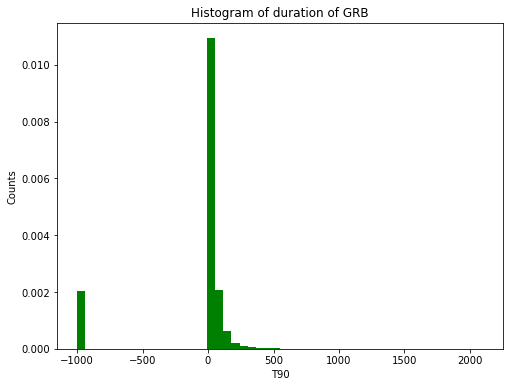

In [5]:
plt.hist(T90, bins = 50, lw = 2, color = 'green', density=True);
plt.xlabel("T90")
plt.ylabel('Counts')
plt.title('Histogram of duration of GRB')

We see the presence of non sense number T90 = -999, it's a custom of the catalougs of missing and problematic observations. 
Let's take only the positive value and use the log values.

Text(0.5, 1.0, 'Histogram of duration of GRB')

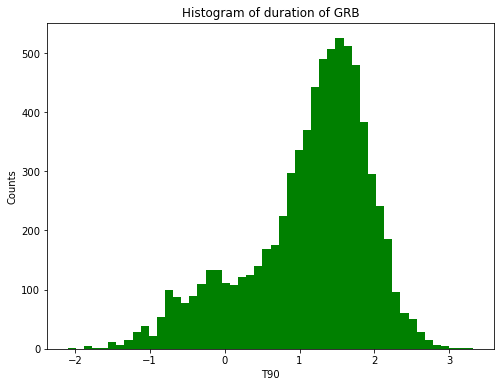

In [6]:
T90 = T90[T90 > 0]
logT90 = np.log10(T90)
plt.hist(logT90, bins = 50, lw = 2, color = 'green');
plt.xlabel("T90")
plt.ylabel('Counts')
plt.title('Histogram of duration of GRB')

It seems to show a bimodality but let's use **KDE** ( Kernel Density Estimation), a method to obtain a better visualization.
We use gaussian kernels.

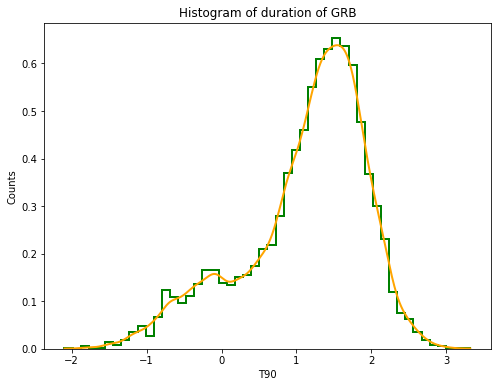

In [7]:
from sklearn.neighbors import KernelDensity
xgrid = np.linspace(logT90.min(),logT90.max(),1000)  

def kde_sklearn(data, bandwidth,  kernel):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

PDF = kde_sklearn(logT90,bandwidth=0.1, kernel="gaussian") 

plt.hist(logT90, bins=50, density=True, histtype="step", lw = 2, color = 'green');
plt.plot(xgrid,PDF, color = 'orange', lw = 2) 
plt.xlabel("T90")
plt.ylabel('Counts')
plt.title('Histogram of duration of GRB')
plt.show()

We are satisfied by this and we trust the astrophysics literature about two modes. Let's procede finding the two modes using an Unsupervised learning, the clustering.

## K-Means Clustering

This method require to give the expected number of cluster, i.e. 2 in our case.

Value of the two centers in seconds: 0.873 32.844
Value of the threshold in seconds: 5.612


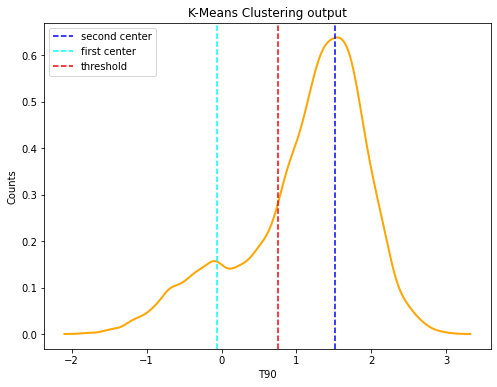

In [8]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

#write data in the correct format for sklearn
X = logT90[:,np.newaxis]


clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points


#let's be sure that the centers are sorted every time me send the code
if (centers[0] > centers[1]):
    centers = centers[::-1]
    labels = labels[::-1]

center_1 = round(10**(centers[0,0]), 3)
center_2 = round(10**(centers[1,0]), 3)
print("Value of the two centers in seconds:" , center_1, center_2 )



# plot the data color-coded by cluster id
plt.plot(xgrid,PDF, color = 'orange', lw = 2) 
plt.axvline(x = centers[1], color= 'blue', linestyle = '--' , label = 'second center') 
plt.axvline(x = centers[0], color= 'cyan' , linestyle = '--' , label = 'first center') 

#to find the threshold just compure the mean between the last point of the first cluster and the first point
#of the second cluster, this is possible since we are in 1-D

threshold = np.mean([max(X[labels == 0, 0]),min(X[labels == 1, 0])])
plt.axvline(x = threshold, color= 'red' , linestyle = '--' , label = 'threshold') 
print("Value of the threshold in seconds: %.3f"  % 10**threshold )

plt.title('K-Means Clustering output');
plt.xlabel('T90')
plt.ylabel('Counts')
plt.legend(loc = 'upper left')

## Mean-Shift Clustering

With this clustering algorithm we don't need to provide the number of cluster I want  to find.

In [9]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth 

bandwidth = 0.4

clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X)
labels_ms = clustering.labels_
centers_ms = clustering.cluster_centers_

#let's be sure that the centers are sorted every time me send the code
if (centers_ms[0] > centers_ms[1]):
    centers_ms = centers_ms[::-1]
    labels_ms = labels_ms[::-1]




labels_unique = np.unique(labels_ms)
n_clusters_ = len(labels_unique)

print(labels_unique)
center_ms_1 = round(10**(centers_ms[0,0]), 3)
center_ms_2 = round(10**(centers_ms[1,0]), 3)
print("Value of the two centers in seconds:" , center_ms_1, center_ms_2 )
print("Number of estimated clusters : %d" % n_clusters_)

[0 1]
Value of the two centers in seconds: 1.074 31.443
Number of estimated clusters : 2


Value of the threshold in seconds: 5.612


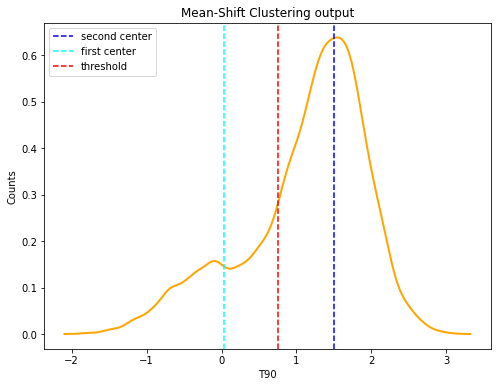

In [10]:
plt.plot(xgrid,PDF, color = 'orange', lw = 2) 
plt.axvline(x = centers_ms[1], color= 'blue', linestyle = '--' , label = 'second center') 
plt.axvline(x = centers_ms[0], color= 'cyan' , linestyle = '--' , label = 'first center') 

threshold_ms = np.mean([max(X[labels_ms == 0, 0]),min(X[labels_ms == 1, 0])])
plt.axvline(x = threshold_ms, color= 'red' , linestyle = '--' , label = 'threshold') 
print("Value of the threshold in seconds: %.3f"  % 10**threshold_ms )

plt.title('Mean-Shift Clustering output');
plt.xlabel('T90')
plt.ylabel('Counts')
plt.legend(loc = 'upper left')

## Comparison between K-Means and Mean-Shift

To compare the two methods that we used, firstly we plot the estimated centers and then the Confusion Matrix.

In [11]:
print("Value of the two centers in seconds, with K-Means clustering:" , center_1, center_2 )
print("Value of the two centers in seconds, with Mean-Shift clustering:" , center_ms_1, center_ms_2 )

Value of the two centers in seconds, with K-Means clustering: 0.873 32.844
Value of the two centers in seconds, with Mean-Shift clustering: 1.074 31.443


Confusion_Matrix between K-Means and Mean-Shift
[[5481   66]
 [   0 1868]]


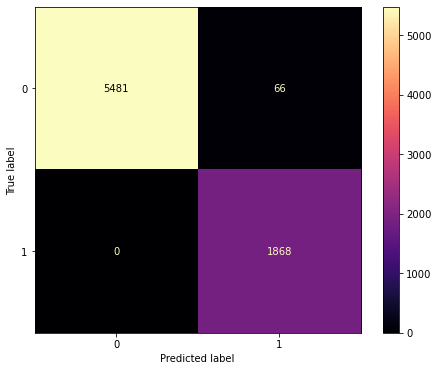

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Confusion_Matrix_1 = confusion_matrix(labels ,labels_ms)
print('Confusion_Matrix between K-Means and Mean-Shift')
print(Confusion_Matrix_1)

disp = ConfusionMatrixDisplay(confusion_matrix = Confusion_Matrix_1)

disp.plot( cmap = 'magma')
plt.show()

We observe a confusion between points classified by K-means in the cluster with center $\sim$ 32 sec, and by Mean-Shift into the cluster arouund $\sim$ 1 sec.

## Gaussian Mixture

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. 

In [13]:
from sklearn.mixture import GaussianMixture

We clearly see, by eyes and by previous analysis, that we should use a mixture of two guaussian, but being pedantry let's compare models with a mixture of different number of gaussian with the AIC

[18151.9344221316, 16561.25899575962, 16595.408362209415, 16618.357696910683, 16614.784113663743, 16631.987965814238, 16639.378929932263, 16630.825389568497, 16610.708287356494]


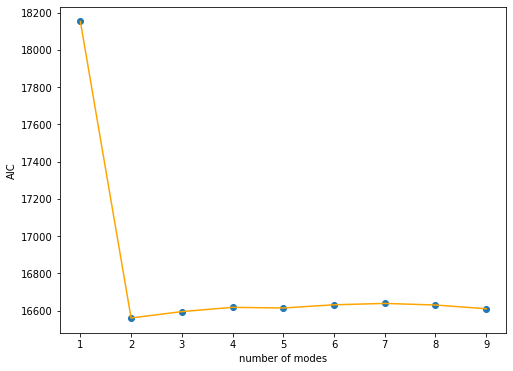

In [14]:
N = np.arange(1, 10)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]

print(AIC)
plt.plot(N, AIC, color = 'orange')
plt.scatter(N, AIC)

plt.xlabel('number of modes')
plt.ylabel('AIC')
plt.show()

As we expected let's take into account the model with just two gaussians.

Value of the two centers in seconds: 0.928 30.657
Value of the threshold in seconds: 5.612


C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_240\4144139910.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(xgrid, pdf_gm, '--k', color ='green', label = 'Gaussian Mixture')


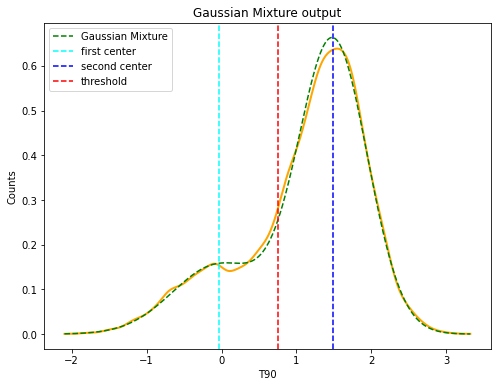

In [15]:
gm = GaussianMixture(n_components=2, covariance_type='diag').fit(X)
plt.plot(xgrid,PDF, color = 'orange', lw = 2) 
pdf_gm =  np.exp(gm.score_samples(xgrid.reshape(-1,1)))

plt.plot(xgrid, pdf_gm, '--k', color ='green', label = 'Gaussian Mixture') 


mean_gm = gm.means_
labels_gm = gm.predict(X)

#let's be sure that the centers are sorted every time me send the code
if (mean_gm[0] > mean_gm[1]):
    mean_gm = mean_gm[::-1]
    labels_gm = labels_gm[::-1]

center_gm_1 = round(10**mean_gm[0,0],3)
center_gm_2 = round(10**mean_gm[1,0],3)
print("Value of the two centers in seconds:" , center_gm_1, center_gm_2)


plt.axvline(x = mean_gm[0], color= 'cyan' , linestyle = '--' , label = 'first center')
plt.axvline(x = mean_gm[1], color= 'blue', linestyle = '--' , label = 'second center') 



threshold_gm = np.mean([max(X[labels_gm == 0, 0]),min(X[labels_gm == 1, 0])])
plt.axvline(x = threshold_gm, color= 'red' , linestyle = '--' , label = 'threshold') 
print("Value of the threshold in seconds: %.3f"  % 10**threshold_gm )






plt.title('Gaussian Mixture output');
plt.xlabel('T90')
plt.ylabel('Counts')
plt.legend(loc = 'upper left')


## Comparison between the three methods

In [16]:
print("Value of the two centers in seconds, with K-Means clustering:" , center_1, center_2 )
print("Value of the two centers in seconds, with Mean-Shift clustering:" , center_ms_1, center_ms_2 )
print("Value of the two centers in seconds, with Gaussian Mixture :" , center_gm_1, center_gm_2 )

Value of the two centers in seconds, with K-Means clustering: 0.873 32.844
Value of the two centers in seconds, with Mean-Shift clustering: 1.074 31.443
Value of the two centers in seconds, with Gaussian Mixture : 0.928 30.657


In [17]:
print("Value of the threshold, with K-Means clustering: %.3f"  %threshold )
print("Value of the threshold, with Mean-Shift clustering: %.3f"   %threshold_ms)
print("Value of the threshold, with Gaussian Mixture: %.3f"  %threshold_gm )

Value of the threshold, with K-Means clustering: 0.749
Value of the threshold, with Mean-Shift clustering: 0.749
Value of the threshold, with Gaussian Mixture: 0.749


Confusion_Matrix between K-Means and Gaussian Mixture
[[5547    0]
 [ 246 1622]]


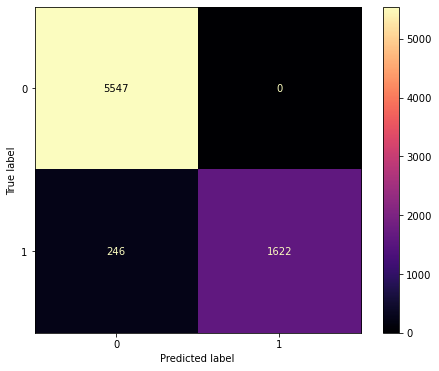

Confusion_Matrix between Mean-Shift and K-Means
[[5481    0]
 [ 312 1622]]


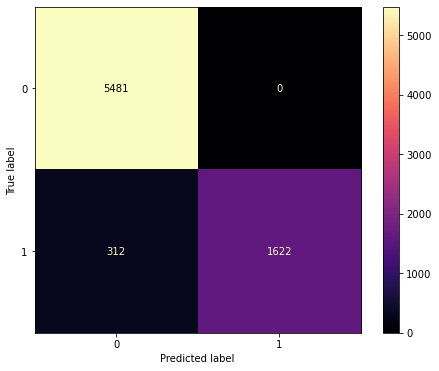

In [18]:
Confusion_Matrix_2 = confusion_matrix(labels ,labels_gm)
print('Confusion_Matrix between K-Means and Gaussian Mixture')
print(Confusion_Matrix_2)

disp = ConfusionMatrixDisplay(confusion_matrix = Confusion_Matrix_2)

disp.plot( cmap = 'magma')
plt.show()

Confusion_Matrix_3 = confusion_matrix(labels_ms ,labels_gm)
print('Confusion_Matrix between Mean-Shift and K-Means')
print(Confusion_Matrix_3)


disp = ConfusionMatrixDisplay(confusion_matrix = Confusion_Matrix_3)

disp.plot( cmap = 'magma')
plt.show()


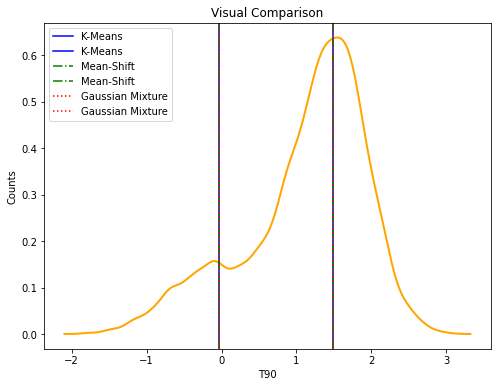

In [19]:
plt.plot(xgrid,PDF, color = 'orange', lw = 2)


plt.axvline(x = mean_gm[0], color= 'blue' , linestyle = '-' , label = 'K-Means')
plt.axvline(x = mean_gm[1], color= 'blue', linestyle = '-' , label = 'K-Means') 

plt.axvline(x = mean_gm[0], color= 'green' , linestyle = '-.' , label = 'Mean-Shift')
plt.axvline(x = mean_gm[1], color= 'green', linestyle = '-.' , label = 'Mean-Shift') 

plt.axvline(x = mean_gm[0], color= 'red' , linestyle = ':' , label = 'Gaussian Mixture')
plt.axvline(x = mean_gm[1], color= 'red', linestyle = ':' , label = 'Gaussian Mixture') 

plt.title('Visual Comparison');
plt.xlabel('T90')
plt.ylabel('Counts')
plt.legend(loc = 'upper left')
